In [ ]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

In [248]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [380]:
# subs = ['R1065J','R1492J','R1525J'] # killer subs

subs = ['R1486J'] #['R1144E'] #['R1065J'] #'R1035M'] #['R1108J'] # R1065J # 'R1035M' #R1086M # R1525J

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
sub_df = sub_df[1:2]
sub_df.iloc[0]

# using R1065J, session 2:3 and R1486J, session 1:2

# R1108J, session 1:2 solid. # R1144E, 1:2 not bad, R12369E, 2:3 not bad


Recognition                                                          NaN
all_events             protocols/r1/subjects/R1486J/experiments/catFR...
contacts               protocols/r1/subjects/R1486J/localizations/0/m...
experiment                                                        catFR1
import_type                                                        build
localization                                                           0
math_events            protocols/r1/subjects/R1486J/experiments/catFR...
montage                                                                0
original_experiment                                                  NaN
original_session                                                     NaN
pairs                  protocols/r1/subjects/R1486J/localizations/0/m...
ps4_events                                                           NaN
session                                                                1
subject                                            

In [381]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0

recall_minimum = 2000 # 2000 is default
region_name = 'HPC' #'ENT' #'HPC' #ENT #HPC # PHC # AMY #ENTPHC # nonHPC_MTL
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###
%autoreload
# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; HFA_array = []
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

for row in sub_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            # HFA_array = superVstack(HFA_array,dat['HFA_array'])
            
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            
#             # specific to whole_encoding
#             if selected_period == 'encoding':
            session_events = session_events.append(dat['session_events']) # doesn't append in place 

            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array'])   
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)
session_events['channel_num'] = channel_nums_array # append channels into the df

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.append(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
# ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
    

**Done reading data**
**Done translating to ripple_array frame**!!
...
From 1/1 sessions with >0 HPC electrodes
Total trials: 1296
Unique sessions: 1
...from 1 patients
Number of electrodes: 9
Electrode regions X sessions:
3 for "ca1"
6 for "dg"


(1296, 1500)

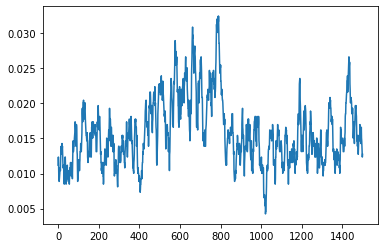

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


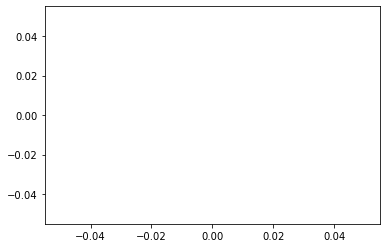

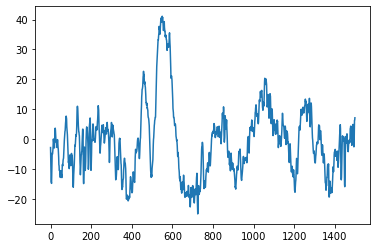

1296

1296

1296

1296

1296

1296

1296

1296

In [382]:
np.shape(ripple_array)
plot(np.mean(ripple_array,0)); show()
plot(np.mean(HFA_array,0)); show()
plot(np.mean(raw_eeg,0)); show()
# np.shape(HFA_array)
# plot(np.mean(HFA_array,0)); show()

# these should all be the same length!
len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(session_name_array)


## Get start_array

In [383]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = False   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for anywhere not in HPC like ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'dg' #['ca1','dg'] #'dg' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# this one list did not have 27 word presentations, so remove it
if exp == 'RepFR1':
    updated_recalls[(np.array(session_name_array)=='R1579T-1') & (np.array(list_num_key)==16)] = 0
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval','whole_encoding','whole_retrieval']:
    list_recall_num_array = np.array(list_recall_num_array)[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]

# specific to encoding

# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

# if selected_period in ['encoding','whole_encoding']:
encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]
word_correct_array = word_correct_array[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
# if selected_period == 'encoding':    
#     session_events = session_events[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
print('...from '+str(len(np.unique(session_name_array)))+' sessions')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 9
from 1 sessions from 1 subjects with trial nums:
[144. 144. 144. 144. 144. 144. 144. 144. 144.]
Trial sum = 1296.0
['"dg"', '"dg"', '"ca1"', '"dg"', '"dg"', '"dg"', '"ca1"', '"dg"', '"ca1"']
Number of sub_sess names: 9
Got encoding start_array!
Got start_array with 1296 trials!
Number of electrodes: 9
...from 1 patients
...from 1 sessions
# of trials: 1296
Total # of ripples: 1893
Overall ripple rate: 0.487 Hz


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## get elec_regions to figure out HPC channels

In [384]:
selected_period = 'encoding' 
# 'surrounding_recall': aligned to time of free recall 
# 'encoding': aligned to word_on 

recall_type_switch = 0 # how do we select recalls?? Numbers 0:3

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels

remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###

min_ripple_rate = 0.1 # Hz. # 0.1 for hamming
max_ripple_rate = 1.5 # Hz. # 1.5 for hamming
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them # 0.05 for hamming
max_electrode_by_electrode_correlation = 0.2 #??? # 0.2 for hamming

filter_type = 'hamming' # see local version below for details 

# recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_whole_time = 1000*np.round(12*(1.6+0.875),1) # 0.875 is average of 0.75-1.0 s so 29.7 is average encoding length
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

### END PARAMS ###

# get region label
if selected_region == HPC_labels:
    region_name = 'HPC'
    
    
for row in sub_df.itertuples(): #sub_df.itertuples():   
    sub = row.subject; session = row.session; exp = row.experiment
    mont = int(row.montage); loc = int(row.localization)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
    # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
    if exp == 'RepFR1':
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)]
    else:
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...False for instrusions).        
    word_evs = evs[evs['type']=='WORD'] # get words 

    # select which recalls??         
    [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)

    _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once

    # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists (practice is -1 in FR1/catFR1 and 0 in RepFR1)
    good_recalls = selected_recalls_idxs & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > 0) & (nonrepeat_indicator>0) ##^
    evs_free_recall = evs_free_recall[good_recalls]

    # get temp key of recalls that lead to intrusions ~~~
    pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)

    if len(evs_free_recall)==0: #...and that any are left!
        continue

    # get output position in each list for this session's recalls
    session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)

    pairs = reader.load('pairs')
    try:
        localizations = reader.load('localization')
    except:
        localizations = []
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 

#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

    # load eeg
    if selected_period == 'surrounding_recall':
        total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
        total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
        kept_recalls = kept_recalls + len(evs_free_recall)
        eeg_events = evs_free_recall

        # fix EEG offset due to Unity implementation error @@
#         init_time = eeg_events.iloc[0].eegoffset
        eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
#         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))          

    elif selected_period == 'encoding':
        ## apparently there are repeated words?? should add program to check and remove
        # I'm going to save encoding word events too, but need a mask to keep track of:
        # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
        evs_encoding_words = evs[evs.type=='WORD']
        evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
        evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
        encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
        encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
        encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
        # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
        eeg_events = evs_encoding_words

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:279: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  json_normalize(flat_contact_data).set_index('name'),
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:280: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  json_normalize(flat_pairs_data).set_index('names')
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)


In [385]:
channel_keep_idxs = []
for i_elec,elec in enumerate(elec_regions):
    if elec in selected_region:
        print(str(i_elec)+', '+elec)
        channel_keep_idxs.append(i_elec)
print(channel_keep_idxs)
np.shape(start_array)


37, "dg"
38, "dg"
39, "ca1"
90, "dg"
91, "dg"
101, "dg"
102, "ca1"
144, "dg"
145, "ca1"
[37, 38, 39, 90, 91, 101, 102, 144, 145]


(1296, 1500)

## let's look at some of these SWR traces! 

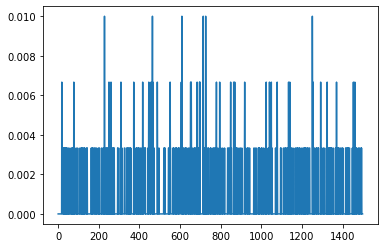

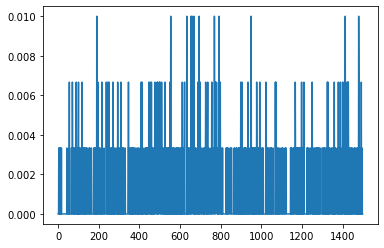

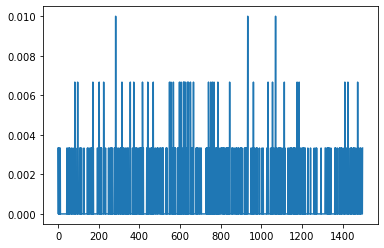

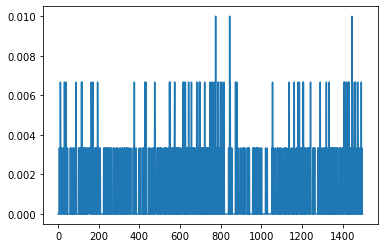

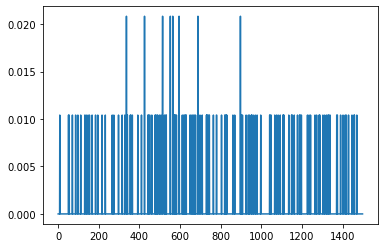

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


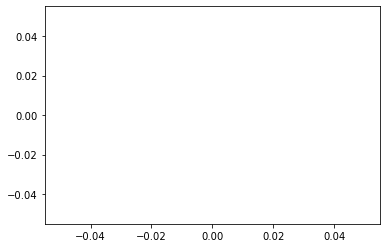

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


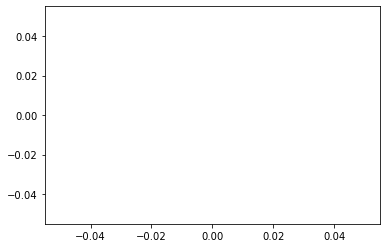

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


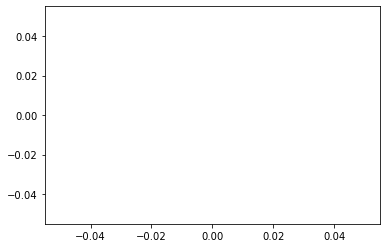

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


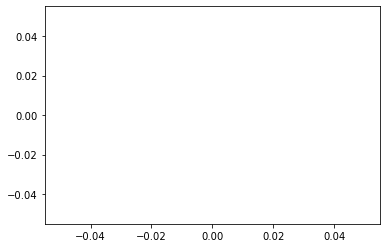

In [386]:
for el in range(len(channel_keep_idxs)):
    first_trial = 300*(el)
    last_trial = 300*(el+1)
    plt.plot(np.mean(start_array[first_trial:last_trial,1:],0)); plt.show()

In [387]:
rel_start = psth_start-eeg_buffer+align_adjust
rel_stop = psth_end+eeg_buffer+align_adjust
print(rel_start); print(rel_stop)
eeg_events[0:3]
pairs[0:3]
eeg = reader.load_eeg(events=eeg_events, rel_start=rel_start,rel_stop=rel_stop, clean=True, scheme=pairs) #**

-1000
2600


,eegoffset,category,category_num,eegfile,exp_version,experiment,intrusion,is_stim,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,recog_resp,recog_rt,recognized,rectime,rejected,serialpos,session,stim_list,stim_params,subject,type
50,635758,Vegetables,17,R1486J_catFR1_1_27Jun19_1332.h5,,catFR1,-999,False,CARROT,266,1,0,-1,1561643210437,NON-STIM,r1,True,-999,-999,-999,16135,-999,1,1,False,[],R1486J,WORD
52,638359,Vegetables,17,R1486J_catFR1_1_27Jun19_1332.h5,,catFR1,-999,False,CORN,272,1,0,-1,1561643213035,NON-STIM,r1,True,-999,-999,-999,21648,-999,2,1,False,[],R1486J,WORD
54,640756,Flowers,6,R1486J_catFR1_1_27Jun19_1332.h5,,catFR1,-999,False,PETUNIA,128,1,0,-1,1561643215436,NON-STIM,r1,True,-999,-999,-999,10322,-999,3,1,False,[],R1486J,WORD


,contact_1,contact_2,label,is_stim_only,type_1,type_2,avg.region,avg.x,avg.y,avg.z,avg.corrected.region,avg.corrected.x,avg.corrected.y,avg.corrected.z,hcp.region,...,ind.corrected.x,ind.corrected.y,ind.corrected.z,mni.region,mni.x,mni.y,mni.z,stein.region,stein.x,stein.y,stein.z,vox.region,vox.x,vox.y,vox.z
0,1,2,ROF1-ROF2,False,D,D,None,8.520068,30.036644,-18.179098,None,8.520068,30.036644,-18.179098,None,...,10.303655,52.84311,-12.443980,,8.55732,40.45325,-18.183905,None,None,None,None,None,245.0,141.0,110.0
1,2,3,ROF2-ROF3,False,D,D,None,13.195887,24.153883,-17.638202,None,13.195887,24.153883,-17.638202,None,...,13.126660,51.89091,-10.772594,,12.27935,39.95165,-16.548444,None,None,None,None,None,239.0,142.0,114.0
2,3,4,ROF3-ROF4,False,D,D,None,19.727617,17.814091,-20.729571,None,19.727617,17.814091,-20.729571,None,...,15.949660,50.93866,-9.101209,,15.32455,39.45885,-15.370271,None,None,None,None,None,233.0,143.0,118.0


In [388]:
# have eeg_events...want to get HFA to match the 5100 x 1500 ripple start_array

from scipy.signal import firwin,filtfilt,kaiserord
from scipy.stats import zscore
from ptsa.data.filters import ButterworthFilter, ResampleFilter, MorletWaveletFilter
import xarray as xarray

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 500 # buffer to add to either end of IRI when processing eeg #**   

psth_start = pre_encoding_time
psth_end = encoding_time
align_adjust = 0 # only for whole_encoding

eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) #**
        
# event X channel X time

sr = eeg.samplerate

eeg_ptsa = eeg.to_ptsa()
eeg = None # clear variable

# take only channels you need
eeg_ptsa = eeg_ptsa[:,channel_keep_idxs,:]

    # # line removal...don't do 120 for now (I never see any line noise there for whatever reason)
    # eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    # eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

# let's save HFA too
HFA_freqs = np.logspace(np.log10(64),np.log10(178),10)
# if sub == 'R1525J':
HFA_eeg = ButterworthFilter(freq_range=[118.,122.], filt_type='stop', order=4).filter(eeg_ptsa)
HFA_eeg = ButterworthFilter(freq_range=0.5, filt_type='highpass',order=4).filter(HFA_eeg) 
HFA_morlet = MorletWaveletFilter(freqs=HFA_freqs, output='power', width=5, verbose=True).filter(HFA_eeg)
# else:
#     HFA_eeg = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[118.,122.], filt_type='stop', order=4).filter()
#     HFA_eeg = ButterworthFilter(timeseries=HFA_eeg, freq_range=0.5, filt_type='highpass',order=4).filter() 
#     HFA_morlet = MorletWaveletFilter(timeseries=HFA_eeg, freqs=HFA_freqs, output='power', width=5, verbose=True).filter()    

# now can remove buffers
sr_factor = 1000/sr
HFA_morlet = HFA_morlet[:,:,:,int(eeg_buffer/sr_factor):int(np.shape(HFA_morlet)[3]-(eeg_buffer/sr_factor))]
HFA_morlet = xarray.ufuncs.log10(HFA_morlet, out=HFA_morlet.values)

# resample down to 500 Hz
# if sub == 'R1525J':
HFA_morlet = ResampleFilter(resamplerate=desired_sample_rate).filter(HFA_morlet) # axes are freqs (10) X words X pairs X bins after downsample
# else:
#     HFA_morlet = ResampleFilter(timeseries=HFA_morlet,resamplerate=desired_sample_rate).filter() # axes are freqs (10) X words X pairs X bins after downsample

# resample the raw to 500 Hz after removing buffers
temp_raw_eeg = copy(HFA_eeg)
HFA_eeg = HFA_eeg[:,:,int(eeg_buffer/sr_factor):int(np.shape(HFA_eeg)[2]-(eeg_buffer/sr_factor))]
# if sub == 'R1525J':
HFA_eeg = ResampleFilter(resamplerate=desired_sample_rate).filter(HFA_eeg) 
# else:
#     HFA_eeg = ResampleFilter(timeseries=HFA_eeg,resamplerate=desired_sample_rate).filter() 

#         # zscore across events & time bins # doing it differently now after talking to Mike 2022-03-08
#         HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(HFA_morlet, axis=(1,3)) 
# z-score using std of time bin averaged instead (mean is same either way)
HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(np.mean(HFA_morlet, axis=3),axis=1)
HFA_morlet = np.mean(HFA_morlet,0) # mean over the 10 frequencies (now down to events X pairs X 100 ms bins)
              
'Initial shape:'
np.shape(HFA_morlet)
HFA_array = []
raw_eeg = []
raw_eeg_with_buffers = []
for el in range(np.shape(HFA_morlet)[1]):
    first_trial = 300*(el)
    last_trial = 300*(el+1)
    HFA_array = superVstack(HFA_array,np.squeeze(HFA_morlet[:,el,:]))
    raw_eeg = superVstack(raw_eeg,np.squeeze(HFA_eeg[:,el,:]))
    raw_eeg_with_buffers = superVstack(raw_eeg_with_buffers,np.squeeze(temp_raw_eeg[:,el,:]))
'Final shape:'
np.shape(HFA_array)

baseline_voltages = np.mean(raw_eeg_with_buffers,1)
raw_eeg_with_buffers = None # got the baseline so don't need the rest

CPP total time wavelet loop:  1.0186104774475098


'Initial shape:'

(144, 9, 1500)

'Final shape:'

(1296, 1500)

In [389]:
'Initial shape:'
np.shape(HFA_morlet)
HFA_array = []
raw_eeg = []
for el in range(np.shape(HFA_morlet)[1]):
    first_trial = 300*(el)
    last_trial = 300*(el+1)
    HFA_array = superVstack(HFA_array,np.squeeze(HFA_morlet[:,el,:]))
    raw_eeg = superVstack(raw_eeg,np.squeeze(HFA_eeg[:,el,:]))
'Final shape:'
np.shape(HFA_array)
np.shape(raw_eeg)
np.shape(start_array)
np.shape(ripple_array)

from scipy.stats import zscore
HFA_array = zscore(HFA_array,axis=None)

'Initial shape:'

(144, 9, 1500)

'Final shape:'

(1296, 1500)

(1296, 1500)

(1296, 1500)

(1296, 1500)

## Now have equal sized arrays of ripple starts, HFA, and raw eeg

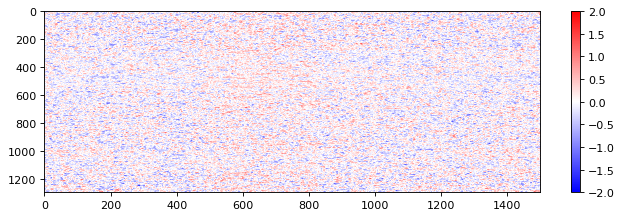

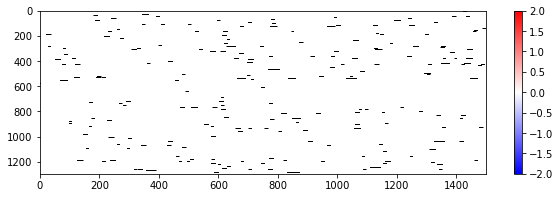

In [390]:
fig,ax = plt.subplots(figsize=(10,3),dpi=80)
cax = plt.imshow(HFA_array,cmap='bwr',interpolation=None,aspect='auto',vmin=-2,vmax=2); 
cbar = fig.colorbar(cax,ax=ax)
plt.show()
fig,ax = plt.subplots(figsize=(10,3)) #,dpi=80)
plt.imshow(ripple_array,cmap='binary',interpolation='nearest',aspect='auto',vmin=0,vmax=1)
cbar = fig.colorbar(cax,ax=ax)
plt.show()

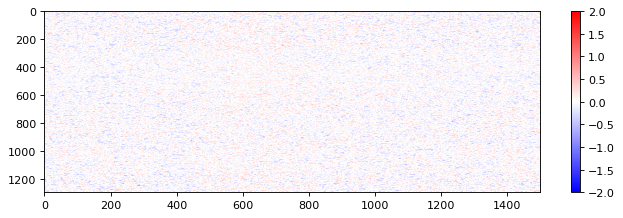

In [391]:
# Let's create a matrix with the ripples removed and I'll plot the remaining z-scores over 2, 1.5, and 1 SD

HFA_array_no_ripples = copy(HFA_array)
for trial in range(np.shape(ripple_array)[0]):
    trial_ripples = np.where(ripple_array[trial,1:])[0]
    for time_point in trial_ripples:
        HFA_array_no_ripples[trial,time_point] = 0 # put in zero for every point with ripple

fix,ax = plt.subplots(figsize=(10,3),dpi=80)
plt.imshow(HFA_array_no_ripples,cmap='bwr',interpolation=None,aspect='auto',vmin=-5,vmax=5); 
cbar = fig.colorbar(cax,ax=ax)
plt.show()       

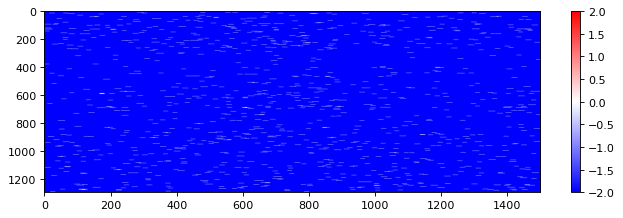

In [392]:
# now keep only bouts of HFA above SD thresh >min_length ms

SD_thresh = 0.75
min_length = 15

def filter_binary_array(binary_array,min_length):

    # Initialize variables
    count = 0  # count of consecutive Trues
    start_index = None  # starting index of a sequence of Trues
    
    # Create a copy of the array to modify and return
    filtered_array = np.copy(binary_array)
    
    # Iterate through the array
    for i, bit in enumerate(binary_array):
        if bit:
            # If this is the start of a new sequence of Trues, remember the start index
            if start_index is None:
                start_index = i
            count += 1
        else:
            # If the sequence of Trues is shorter than 20, set all to False
            if 0 < count < min_length:
                filtered_array[start_index:start_index+count] = False
            
            # Reset count and start index
            count = 0
            start_index = None
    
    # Handle the case where the array ends with a sequence of Trues
    if 0 < count < min_length:
        filtered_array[start_index:start_index+count] = False
        
    return filtered_array

# okay that looks good, now let's try creating a >2 SD binary

HFA_1_sd = copy(HFA_array_no_ripples)
HFA_1_sd = HFA_1_sd>=SD_thresh

# get HFA bouts

HFA_bout_array = []
for trial in range(np.shape(HFA_1_sd)[0]):
    HFA_bout_array = superVstack(HFA_bout_array,filter_binary_array(HFA_1_sd[trial,:],min_length))
    
fix,ax = plt.subplots(figsize=(10,3),dpi=80)
plt.imshow(HFA_bout_array,cmap='bwr',interpolation=None,aspect='auto')
cbar = fig.colorbar(cax,ax=ax)
plt.show()    

(1296, 1500)


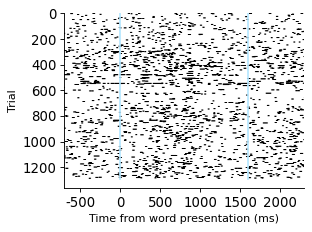

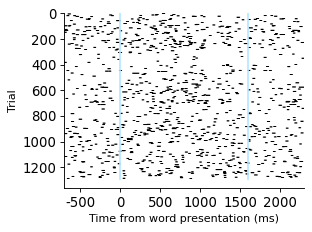

In [393]:
# plot Ripples and HFA bouts

save_plots = 0

# ripples
fix,ax = plt.subplots(figsize=(4,3),dpi=80)
print(np.shape(ripple_array))
imshow(ripple_array,cmap='binary',interpolation=None,aspect='auto',vmax=0.1)
xticks(np.arange(200/2,2700/2+1,250),np.arange(-500,2300+1,500),fontsize=12); 
yticks(fontsize=12)
xlabel('Time from word presentation (ms)')
ylabel('Trial')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# title('Ripples')
plot([700/2,700/2],[0,len(ripple_array)],color=(0.7,0.9,1))
plot([700/2+1600/2,700/2+1600/2],[0,len(ripple_array)],color=(0.7,0.9,1))
tight_layout()
if save_plots == 1:
    plt.savefig('../figures/raw_ripples/'+exp+'_'+sub+'-'+str(session)+'_whole_ripple_plot'+region_name+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True)   

# HFA bouts
fix,ax = plt.subplots(figsize=(4,3),dpi=80)
plt.imshow(HFA_bout_array,cmap='binary',interpolation=None,aspect='auto',vmax=0.1)
xticks(np.arange(200/2,2700/2+1,250),np.arange(-500,2300+1,500),fontsize=12); 
yticks(fontsize=12)
xlabel('Time from word presentation (ms)')
ylabel('Trial')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# title('HFA bouts (ripples removed)')
plot([700/2,700/2],[0,len(ripple_array)],color=(0.7,0.9,1))
plot([700/2+1600/2,700/2+1600/2],[0,len(ripple_array)],color=(0.7,0.9,1))
tight_layout()
if save_plots == 1:
    plt.savefig('../figures/raw_ripples/'+exp+'_'+sub+'-'+str(session)+'_HFA_bouts_plot'+region_name+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 
a=1;

# get raw voltages ±plot_width around each ripple

In [394]:
plot_width = 250
sr_factor = 1000/desired_sample_rate

ripple_raw = []
ripple_HFA = []
for trial in range(np.shape(ripple_array)[0]):
    trial_ripples = np.where(start_array[trial,1:])[0]
    for ripple in trial_ripples:
        if ((ripple>plot_width) and ((ripple+plot_width)<np.shape(start_array)[1])): # make sure not at edges of array
            # find how long this ripple is and its max voltage for alignment
            ripple = ripple+1 # must have been 0-indexed since ripple always starts 1 later
            single_ripple_array = ripple_array[trial,ripple:int(ripple+200/sr_factor)] # first value always 0 so add 1
            if sum(single_ripple_array) == len(single_ripple_array):
                single_ripple_array[-1] = 0 # if never get a 0 will break
            ripple_length = np.where(single_ripple_array==0)[0][0]
            ripple_max = np.argmax(raw_eeg[trial,ripple:ripple+ripple_length])

            # grab first 200 points since that's max ripple length anyway
            ripple_max = ripple_max + ripple # get max of ripple from beginning of trial
            if ((ripple_max>plot_width) and ((ripple_max+plot_width)<np.shape(start_array)[1])):
                # now that you have the ripple
                ripple_raw = superVstack(ripple_raw,
                                         raw_eeg[trial,int(ripple_max-plot_width):int(ripple_max+plot_width)] - baseline_voltages[trial])
                ripple_HFA = superVstack(ripple_HFA,HFA_array[trial,int(ripple_max-plot_width):int(ripple_max+plot_width)])
ripple_raw = ripple_raw/4 # convert Blackrock to uV                

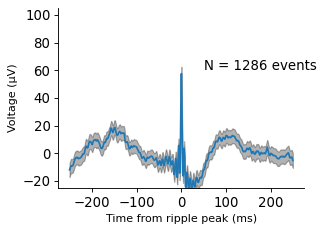

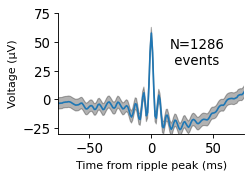

In [406]:
save_plots = 1

np.shape(ripple_raw)
xr = np.arange(-plot_width,plot_width)
fix,ax = plt.subplots(figsize=(4,3),dpi=80)
plot(xr,np.mean(ripple_raw,0)); 
ripple_se = np.std(ripple_raw,0)/np.sqrt(np.shape(ripple_raw)[0])
fill_between(xr,np.mean(ripple_raw,0)-ripple_se, np.mean(ripple_raw,0)+ripple_se,
                     color=(0,0,0), alpha = 0.3, label='_nolegend_')
xticks(fontsize=12)
yticks(fontsize=12)
xlabel('Time from ripple peak (ms)')
ylabel('Voltage (μV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-25,105)
tight_layout()
text(50,60,'N = '+str(np.shape(ripple_raw)[0])+ ' events',fontsize=12)
if save_plots == 1:
    plt.savefig('../figures/raw_ripples/'+exp+'_'+sub+'-'+str(session)+'_averaged_raw_ripples'+region_name+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 

# make same plot with shorter scale
fix,ax = plt.subplots(figsize=(3,2),dpi=80)
plot(xr,np.mean(ripple_raw,0)); 
ripple_se = np.std(ripple_raw,0)/np.sqrt(np.shape(ripple_raw)[0])
fill_between(xr,np.mean(ripple_raw,0)-ripple_se, np.mean(ripple_raw,0)+ripple_se,
                     color=(0,0,0), alpha = 0.3, label='_nolegend_')
xticks(fontsize=12)
yticks(fontsize=12)
xlabel('Time from ripple peak (ms)')
ylabel('Voltage (μV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-75,75)
ax.set_ylim(-30,75)
text(15,30,'N='+str(np.shape(ripple_raw)[0])+ '\n events',fontsize=12)
# tight_layout()
if save_plots == 1:
    plt.savefig('../figures/raw_ripples/'+exp+'_'+sub+'-'+str(session)+'_averaged_raw_ripples_ZOOM_'+region_name+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 
a=1;

In [396]:
# Do the same plot but for my no-ripple HFA matrix

HFA_start_array,_ = getStartEndArrays(HFA_bout_array)

plot_width = 250
sr_factor = 1000/desired_sample_rate

HFA_raw = []
for trial in range(np.shape(HFA_bout_array)[0]):
    trial_ripples = np.where(HFA_start_array[trial,1:])[0]
    for ripple in trial_ripples:
        if ((ripple>plot_width) and ((ripple+plot_width)<np.shape(HFA_start_array)[1])): # make sure not at edges of array
            # find how long this ripple is and its max voltage for alignment
            ripple = ripple+1 # must have been 0-indexed since ripple always starts 1 later
            single_ripple_array = HFA_bout_array[trial,ripple:int(ripple+200/sr_factor)] # first value always 0 so add 1
            if sum(single_ripple_array) == len(single_ripple_array):
                single_ripple_array[-1] = 0
            ripple_length = np.where(single_ripple_array==0)[0][0]
            ripple_max = np.argmax(raw_eeg[trial,ripple:ripple+ripple_length])

            # grab first 200 points since that's max ripple length anyway
            ripple_max = ripple_max + ripple # get max of ripple from beginning of trial
            if ((ripple_max>plot_width) and ((ripple_max+plot_width)<np.shape(HFA_start_array)[1])):
                # now that you have the ripple
                HFA_raw = superVstack(HFA_raw,
                                         raw_eeg[trial,int(ripple_max-plot_width):int(ripple_max+plot_width)] - baseline_voltages[trial])
HFA_raw = HFA_raw/4 # convert Blackrock to uV

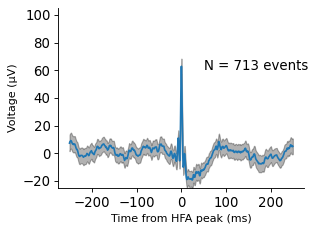

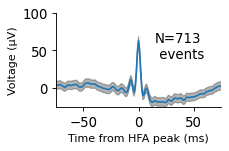

In [407]:
save_plots = 1

np.shape(HFA_raw)
xr = np.arange(-plot_width,plot_width)
fix,ax = plt.subplots(figsize=(4,3),dpi=80)
plot(xr,np.mean(HFA_raw,0)); 
ripple_se = np.std(HFA_raw,0)/np.sqrt(np.shape(HFA_raw)[0])
fill_between(xr,np.mean(HFA_raw,0)-ripple_se, np.mean(HFA_raw,0)+ripple_se,
                     color=(0,0,0), alpha = 0.3, label='_nolegend_')
xticks(fontsize=12)
yticks(fontsize=12)
xlabel('Time from HFA peak (ms)')
ylabel('Voltage (μV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-25,105)
tight_layout()
text(50,60,'N = '+str(np.shape(HFA_raw)[0])+ ' events',fontsize=12)
if save_plots == 1:
    plt.savefig('../figures/raw_ripples/'+exp+'_'+sub+'-'+str(session)+'_averaged_raw_HFA'+region_name+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 
    
# make same plot with shorter scale
fix,ax = plt.subplots(figsize=(3,2),dpi=80)
plot(xr,np.mean(HFA_raw,0)); 
ripple_se = np.std(HFA_raw,0)/np.sqrt(np.shape(HFA_raw)[0])
fill_between(xr,np.mean(HFA_raw,0)-ripple_se, np.mean(HFA_raw,0)+ripple_se,
                     color=(0,0,0), alpha = 0.3, label='_nolegend_')
xticks(fontsize=12)
yticks(fontsize=12)
xlabel('Time from HFA peak (ms)')
ylabel('Voltage (μV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-75,75)
ax.set_ylim(-25,100)
tight_layout()
text(15,40,'N='+str(np.shape(HFA_raw)[0])+ '\n events',fontsize=12)
if save_plots == 1:
    plt.savefig('../figures/raw_ripples/'+exp+'_'+sub+'-'+str(session)+'_averaged_raw_HFA_ZOOM_'+region_name+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 
a=1;